In [55]:
#this notebook try to forecast corona cases
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
import numpy as np



2.2.0


In [2]:
data_raw=pd.read_csv("/content/drive/My Drive/datasets/corona/case_time_series (2).csv")
data_raw

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,30 January,1,1,0,0,0,0
1,31 January,0,1,0,0,0,0
2,01 February,0,1,0,0,0,0
3,02 February,1,2,0,0,0,0
4,03 February,1,3,0,0,0,0
...,...,...,...,...,...,...,...
125,03 June,9689,216876,3789,104064,259,6088
126,04 June,9847,226723,4390,108454,274,6362
127,05 June,9472,236195,4770,113224,286,6648
128,06 June,10408,246603,5433,118657,297,6945


In [0]:
data_raw['Date']=data_raw['Date']+' '+'2020'
data_raw['Date'] =  pd.to_datetime(data_raw['Date'], format='%d %B %Y')

In [4]:
data_raw


,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,2020-01-30,1,1,0,0,0,0
1,2020-01-31,0,1,0,0,0,0
2,2020-02-01,0,1,0,0,0,0
3,2020-02-02,1,2,0,0,0,0
4,2020-02-03,1,3,0,0,0,0
...,...,...,...,...,...,...,...
125,2020-06-03,9689,216876,3789,104064,259,6088
126,2020-06-04,9847,226723,4390,108454,274,6362
127,2020-06-05,9472,236195,4770,113224,286,6648
128,2020-06-06,10408,246603,5433,118657,297,6945


In [5]:
#so now let us drop some columns :)
data_raw.drop(columns={'Total Confirmed','Total Recovered','Total Deceased'})

,Date,Daily Confirmed,Daily Recovered,Daily Deceased
0,2020-01-30,1,0,0
1,2020-01-31,0,0,0
2,2020-02-01,0,0,0
3,2020-02-02,1,0,0
4,2020-02-03,1,0,0
...,...,...,...,...
125,2020-06-03,9689,3789,259
126,2020-06-04,9847,4390,274
127,2020-06-05,9472,4770,286
128,2020-06-06,10408,5433,297


ARIMA stands for Autoregressive Integrated Moving Average and it depends on    
three key variables p, d, q to be successful.

 Those are briefly as follows:


p = number of lags / order of AR terms


d = order of differencing

q = number of lagged forecast errors / order of MA terms

But before that i have ended up in  a confusion that how i can choose columns...

so i gonna try 3 methods

1.each column as a seperate time series training and predicting that

2.the total table as a full time series (using VAR)

3.The confirm case column as seperate time series and recover column as seperate time series with confirm column as exogeneous variable and deceased column as seperate time with confirm case column and recover column as exogenous variable 

So lets try the first method

In [0]:
dt_confirm=data_raw['Daily Confirmed']

The Augmented Dickey Fuller Test (ADF) is unit root test for stationarity. Unit roots can cause unpredictable results in your time series analysis.

The Augmented Dickey-Fuller test can be used with serial correlation.

In [7]:
from statsmodels.tsa.stattools import adfuller
print("p-value:", adfuller(dt_confirm.dropna())[1])

p-value: 1.0


seems like our data is not stationary cause it have an upper trend  so we have to do differencing.
 

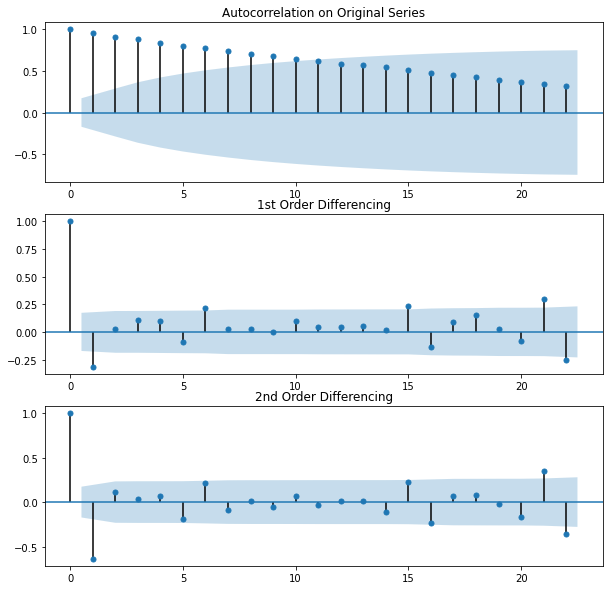

In [8]:
timeseries=dt_confirm
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(timeseries, ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(timeseries.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(timeseries.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

We can see that our time series is stationary for the first differencing so our d=1

NOw let us find the order of AR using the pacf plot

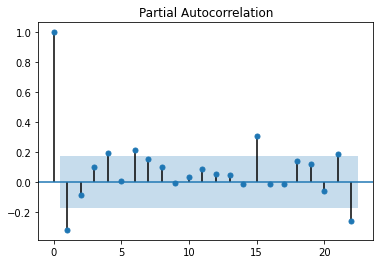

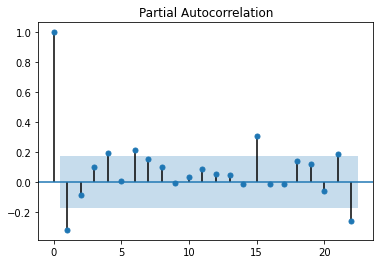

In [9]:
plot_pacf(timeseries.diff().dropna())

Seems like lag 1 is above the significance level

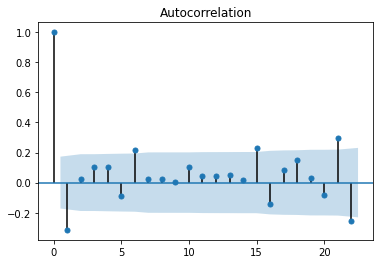

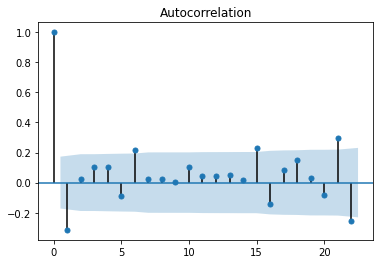

In [10]:
plot_acf(timeseries.diff().dropna())


Now we can see that we can use lag 1 for MA

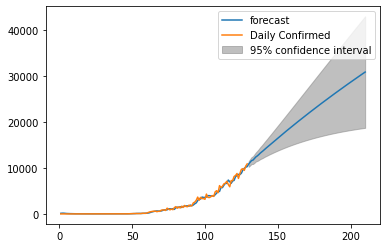

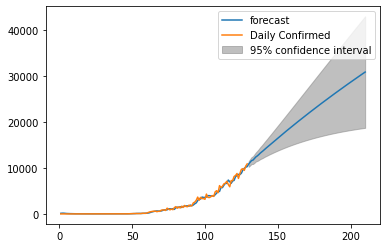

In [20]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(timeseries, order=(6,1,1))
results = model.fit()
results.plot_predict(1, 210)

In [12]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D.Daily Confirmed   No. Observations:                  129
Model:                 ARIMA(6, 1, 1)   Log Likelihood                -923.706
Method:                       css-mle   S.D. of innovations            309.151
Date:                Mon, 08 Jun 2020   AIC                           1865.412
Time:                        08:26:50   BIC                           1891.151
Sample:                             1   HQIC                          1875.870
                                                                              
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     127.4344    112.028      1.138      0.255     -92.137     347.006
ar.L1.D.Daily Confirmed     0.3927      0.096      4.097      0.000       0.205       0.581
ar.L2.D.Daily Confirmed     0.1886      0.094      2.006      0.045       0.004       0.373
ar.L3.D.Daily Confirmed     0.1825      0.095      1.925      0.054      -0.003       0.368
ar.L4.D.Daily Confirmed     0.0788      0.096      0.821      0.412      -0.109       0.267
ar.L5.D.Daily Confirmed    -0.0706      0.096     -0.733      0.464      -0.259       0.118
ar.L6.D.Daily Confirmed     0.2089      0.091      2.289      0.022       0.030       0.388
ma.L1.D.Daily Confirmed    -0.8672      0.051    -17.086      0.000      -0.967      -0.768
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0074           -0.0000j            1.0074           -0.0000
AR.2           -1.3170           -0.0000j            1.3170           -0.5000
AR.3           -0.5501           -1.1738j            1.2964           -0.3197
AR.4           -0.5501           +1.1738j            1.2964            0.3197
AR.5            0.8738           -1.1761j            1.4652           -0.1483
AR.6            0.8738           +1.1761j            1.4652            0.1483
MA.1            1.1531           +0.0000j            1.1531            0.0000
-----------------------------------------------------------------------------
"""

In [0]:
dt_recov=data_raw['Daily Recovered']

The Augmented Dickey Fuller Test (ADF) is unit root test for stationarity. Unit roots can cause unpredictable results in your time series analysis.

The Augmented Dickey-Fuller test can be used with serial correlation.

In [23]:
from statsmodels.tsa.stattools import adfuller
print("p-value:", adfuller(dt_confirm.dropna())[1])

p-value: 1.0


seems like our data is not stationary cause it have an upper trend  so we have to do differencing.
 

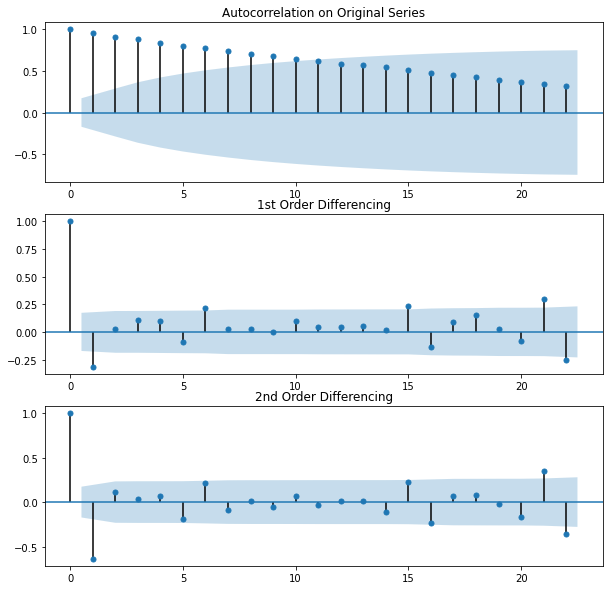

In [24]:
timeseries=dt_confirm
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(timeseries, ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(timeseries.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(timeseries.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

We can see that our time series is stationary for the first differencing so our d=1

NOw let us find the order of AR using the pacf plot

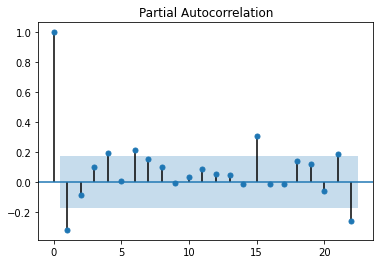

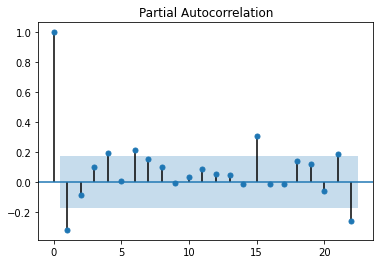

In [25]:
plot_pacf(timeseries.diff().dropna())

Seems like lag 1 is above the significance level

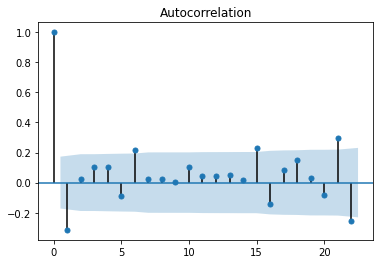

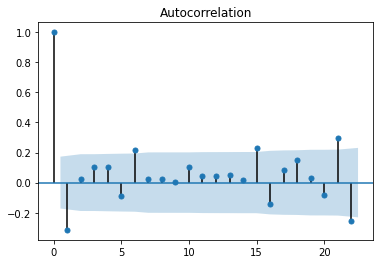

In [26]:
plot_acf(timeseries.diff().dropna())


Now we can see that we can use lag 1 for MA

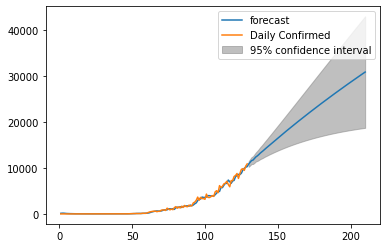

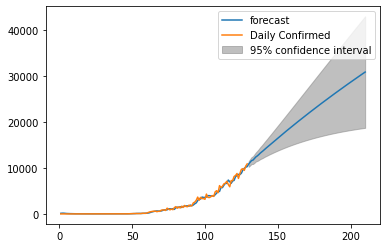

In [32]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(timeseries, order=(6,1,1))
results = model.fit()
results.plot_predict(1, 210)

In [33]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D.Daily Confirmed   No. Observations:                  129
Model:                 ARIMA(6, 1, 1)   Log Likelihood                -923.706
Method:                       css-mle   S.D. of innovations            309.151
Date:                Mon, 08 Jun 2020   AIC                           1865.412
Time:                        09:26:52   BIC                           1891.151
Sample:                             1   HQIC                          1875.870
                                                                              
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     127.4344    112.028      1.138      0.255     -92.137     347.006
ar.L1.D.Daily Confirmed     0.3927      0.096      4.097      0.000       0.205       0.581
ar.L2.D.Daily Confirmed     0.1886      0.094      2.006      0.045       0.004       0.373
ar.L3.D.Daily Confirmed     0.1825      0.095      1.925      0.054      -0.003       0.368
ar.L4.D.Daily Confirmed     0.0788      0.096      0.821      0.412      -0.109       0.267
ar.L5.D.Daily Confirmed    -0.0706      0.096     -0.733      0.464      -0.259       0.118
ar.L6.D.Daily Confirmed     0.2089      0.091      2.289      0.022       0.030       0.388
ma.L1.D.Daily Confirmed    -0.8672      0.051    -17.086      0.000      -0.967      -0.768
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0074           -0.0000j            1.0074           -0.0000
AR.2           -1.3170           -0.0000j            1.3170           -0.5000
AR.3           -0.5501           -1.1738j            1.2964           -0.3197
AR.4           -0.5501           +1.1738j            1.2964            0.3197
AR.5            0.8738           -1.1761j            1.4652           -0.1483
AR.6            0.8738           +1.1761j            1.4652            0.1483
MA.1            1.1531           +0.0000j            1.1531            0.0000
-----------------------------------------------------------------------------
"""

In [0]:
dt_deceas=data_raw['Daily Deceased']

The Augmented Dickey Fuller Test (ADF) is unit root test for stationarity. Unit roots can cause unpredictable results in your time series analysis.

The Augmented Dickey-Fuller test can be used with serial correlation.

In [42]:
from statsmodels.tsa.stattools import adfuller
print("p-value:", adfuller(dt_confirm.dropna())[1])

p-value: 1.0


seems like our data is not stationary cause it have an upper trend  so we have to do differencing.
 

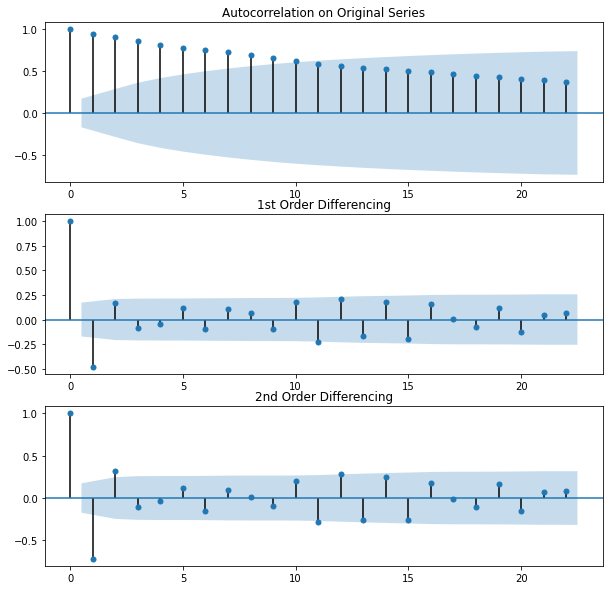

In [43]:
timeseries=dt_deceas
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(timeseries, ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(timeseries.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(timeseries.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

We can see that our time series is stationary for the first differencing so our d=1

NOw let us find the order of AR using the pacf plot

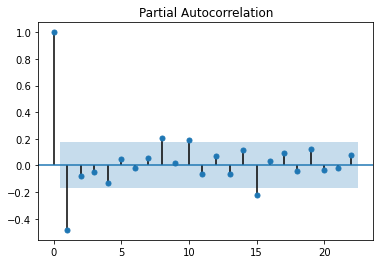

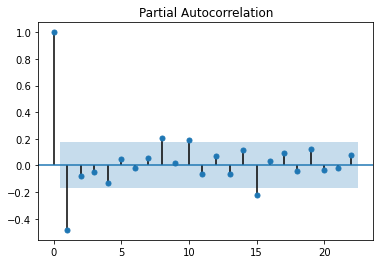

In [44]:
plot_pacf(timeseries.diff().dropna())

Seems like lag 1 is above the significance level

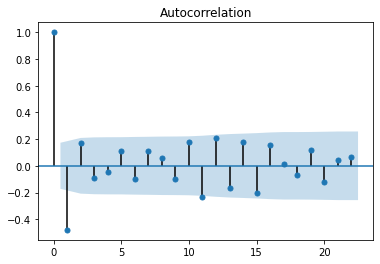

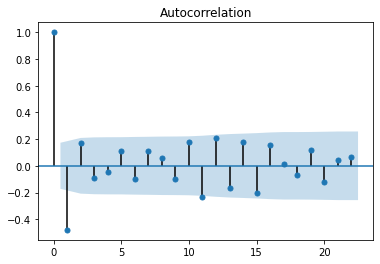

In [45]:
plot_acf(timeseries.diff().dropna())


Now we can see that we can use lag 1 for MA

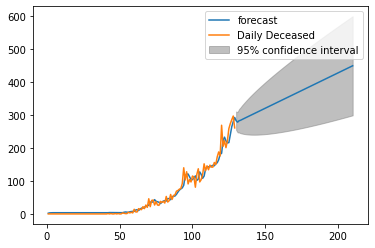

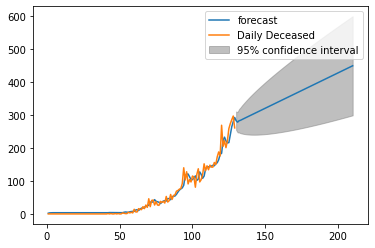

In [47]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(timeseries, order=(1,1,1))
results = model.fit()
results.plot_predict(1, 210)

In [48]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.Daily Deceased   No. Observations:                  129
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -526.813
Method:                       css-mle   S.D. of innovations             14.349
Date:                Mon, 08 Jun 2020   AIC                           1061.626
Time:                        09:30:36   BIC                           1073.065
Sample:                             1   HQIC                          1066.274
                                                                              
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2.1456      0.746      2.876      0.004       0.683       3.608
ar.L1.D.Daily Deceased    -0.3328      0.183     -1.823      0.068      -0.691       0.025
ma.L1.D.Daily Deceased    -0.2164      0.193     -1.118      0.263      -0.596       0.163
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.0052           +0.0000j            3.0052            0.5000
MA.1            4.6212           +0.0000j            4.6212            0.0000
-----------------------------------------------------------------------------
"""